# Mass Modelling and Label Noise Investigation for CHIP Classification 

## Wei Jie Huang - 31500315

# 1. Introduction
This notebook parses through the modelling techniques and methods to find misclassified labels within the datasets. 

Within both supplied datasets, grouping the 88 participants by their unique `MSID` demonstrates no inconsistencies between dataset1 and dataset2 classifications (44 CHIP, 44 Control). 

In addition, within each individual dataset, each read of a particular patient presents the same label; thus for every unique `MSID`, no inconsistent classification arises. From these two observations, it's hypothesised that the label noise is large enough to span both datasets, hence, we cannot ascertain that a particular machine produced a ground truth classification. 

There were two methods in uncovering label noise, the first was utilising a Python package, `cleanlab`, which wraps around sklearn machine learning models working with label noise probabilities as an input; the second consisted of further exploratory analysis of modelling accuracies and averages, inferring structured bias across multiple patients through `MSID` groupings.

**NOTE: Although the notebook seems long, it's due to the outputs in attempt to find accuracies of many models.**

**It is short, in essence, if you skim over model creating and accuracies**

# 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

# preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, explained_variance_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2

# models
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier, LassoCV, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Custom python file for commonly used data preprocessing methods within the project
import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv("../data/chipVariantCalling_run1.tsv", sep='\t')
df2 = pd.read_csv("../data/chipVariantCalling_run2.tsv", sep='\t')


pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

df

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.003600,0.003300,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.000000,1.182210,CHIP
1,4010289633,7281,26,0.003600,0.003300,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.000000,1.182210,CHIP
2,4010289633,7281,26,0.003600,0.003300,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.000000,1.182210,CHIP
3,4010289633,7281,26,0.003600,0.003300,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.000000,1.182210,CHIP
4,4010289633,7282,29,0.004000,0.003600,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.700000,1.061729,CHIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137944,4010290016,731,2,0.002700,0.002800,MODERATE,ZFY,chrY:2848011_C/T,Blank,Blank,NaN,2:2,371:357,1:1,31.000000,1.039170,NaN
1137945,4010290016,731,2,0.002700,0.002800,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.000000,1.022260,NaN
1137946,4010290016,731,2,0.002700,0.002800,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.000000,1.022260,NaN
1137947,4010290016,731,2,0.002700,0.002800,MODERATE,ZFY,chrY:2848029_C/T,Blank,Blank,NaN,2:2,367:359,1:1,37.000000,1.022260,NaN


In [5]:
dataset1 = df.copy(deep=True)
dataset2 = df2.copy(deep=True)

# 3. Data Preprocessing
Although not the main purpose of the notebook, data must be preprocessed before it can run through models, such that outliers 
Most notably, data preprocessing methods have mostly been modulated into a python file `preprocessing.py` for cleaner code. 

To summarise:
- `preprocessing.remove_redundant()`
    - Removes all duplicate rows and remove invalid classifications of `chipOrControl`; these include `blank`, `unknown` and  `NaN`
- `preprocessing.convert_ratios()`
    - Converts columns containing a strings of `a:b` to a float by simple division, a/b. If the function attempts to divide by zero, return is also zero

`preprocessing.remove_redundant()` must be called upon the datasets, as there exists hundreds of thousands of duplicate data which must be parsed. 

`preprocessing.py` documentation can be found here: https://git.infotech.monash.edu/ads2001-s1-2021/ads2001-chip-1/blob/master/CHIP%20Project/preprocessing.py

In [21]:
print("Before removing duplicate rows and invalid labels: ")
print("Rows = ", df.shape[0])

Before removing duplicate rows and invalid labels: 
Rows =  1137949


In [22]:
df = preprocessing.remove_redundant(df)
df2 = preprocessing.remove_redundant(df2)

In [23]:
print("After removing duplicate rows and invalid labels: ")
print("Rows = ", df.shape[0])

After removing duplicate rows and invalid labels: 
Rows =  121936


Next, given that columns `REFBIAS` and `VARBIAS` are string values, convert to float with `preprocessing.convert_ratios()`

In [24]:
df = preprocessing.convert_ratios(df, ["REFBIAS", "VARBIAS"])
df2 = preprocessing.convert_ratios(df2, ["REFBIAS", "VARBIAS"])

Now that data is in the correct format, examine the variables itself via a correlation matrix to visualise if any variables are highly correlated against each other

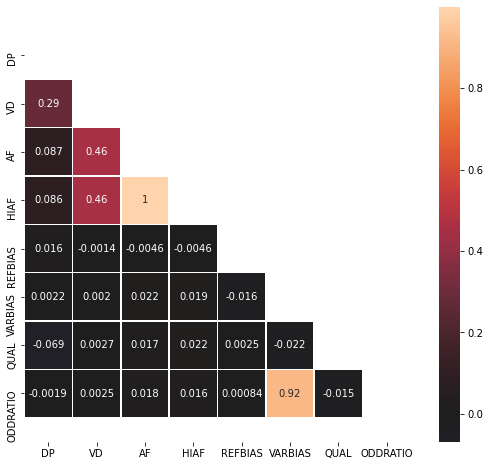

In [25]:
corrs = df.corr() # calculate the correlation table
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) 
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

We can see that `AF` and `HIAF` have exact correlations; `ODDRATIO` and `VARBIAS` contains a very high correlation too. 

However, if we examine `ODDRATIO` itself, an intersting fact arises where DNA sequencing reliability is called into question

In [49]:
zero_OR = dataset1[dataset1['ODDRATIO'] == 0]
print("Frequency of unique strings in BIAS, where ODDRATIO = 0")
zero_OR.BIAS.value_counts()

Frequency of unique strings in BIAS


1:0    40451
1:1     7625
2:0     2885
0:2     2007
1:2     1556
0:0       50
Name: BIAS, dtype: int64

In [50]:
print("Frequency of unique strings in BIAS in original dataset")
dataset1.BIAS.value_counts()

Frequency of unique strings in BIAS in original dataset


2:2    1079156
1:0      40451
1:1       7707
1:2       5691
2:0       2885
0:2       2007
0:0         50
2:1          2
Name: BIAS, dtype: int64

A wide discrepancy between the frequency of values between a dataset containing `ODDRATIO` = 0, and the original is depicted.

The value of `BIAS` determines whether there’s strand bias between the DNA variant read and sequenced data. It consists two numbers. First number is for reference allele. 2nd number is for alternative allele. 

The numbers range from 0-2. 
- 0 means not enough to determine bias. 
- 1 means only one orientation observed. 
- 2 means both orientations observed. 

2:1 would indicate strand bias, but not 1:1. Hence, a distinct correlation between `ODDRATIO` and `BIAS` exists; thus the following datasets have all values of `ODDRATIO = 0` removed, as well as only including instances where `BIAS` = 1:1 or 2:2

A higher level description of variables may be found here: https://github.com/AstraZeneca-NGS/VarDict/wiki/VarDict-Raw-Output 

In [28]:
df = df[df["BIAS"].str.contains("2:2")]
df = df[df['ODDRATIO'] > 0]

df2 = df2[df2["BIAS"].str.contains("2:2")]
df2 = df2[df2['ODDRATIO'] > 0]

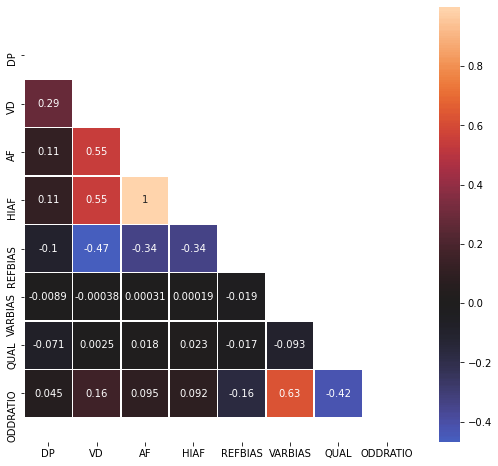

In [29]:
corrs = df.corr() # calculate the correlation table
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) 
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

When `ODDRATIO` AND `BIAS` are filtered, the confusion matrix changes it's correlation values, especially those related to `REFBIAS`.

We can also drop `AF` and `BIAS`, as `HIAF` provides all high quality allele frequency reads (`AF`), while `BIAS` has already been filtered out.

In [11]:
df.drop(["AF", "BIAS"], axis = 1, inplace=True)
df2.drop(["AF" , "BIAS"], axis = 1, inplace=True)

In exploratory data anaysis, it was uncovered that certain `SYMBOL`s (GENE) were prevelant indiciators of `CHIP`. Hence, we one hot encode the top five genes which are associated with `CHIP`  

In [15]:
# Collate names of genes in alphabetical order
genes = sorted(df.SYMBOL.unique())
genes2 = sorted(df2.SYMBOL.unique())

# One hot encode via pd.get_dummies()
df = pd.concat([df,pd.get_dummies(df['SYMBOL'], prefix='GENE')],axis=1)
df2 = pd.concat([df2,pd.get_dummies(df2['SYMBOL'], prefix='GENE')],axis=1)

# Remove other genes from dataframe
df = df[['DP', 'VD', 'AF', 'HIAF', 'IMPACT', 'sampleTimePt', 'gender', 'MSID',
       'REFBIAS', 'VARBIAS', 'QUAL', 'ODDRATIO', 'chipOrControl', 
         'GENE_DNMT3A', 'GENE_TET2', 'GENE_TP53', 'GENE_ASXL1', 'GENE_BCOR']]

df2 = df2[['DP', 'VD', 'AF', 'HIAF', 'IMPACT', 'sampleTimePt', 'gender', 'MSID',
       'REFBIAS', 'VARBIAS', 'QUAL', 'ODDRATIO', 'chipOrControl',
           'GENE_DNMT3A', 'GENE_TET2', 'GENE_TP53', 'GENE_ASXL1', 'GENE_BCOR']]


# Create separate dataframe
encoder = df[['GENE_DNMT3A', 'GENE_TET2', 'GENE_TP53', 'GENE_ASXL1', 'GENE_BCOR']]
encoder2 = df2[['GENE_DNMT3A', 'GENE_TET2', 'GENE_TP53', 'GENE_ASXL1', 'GENE_BCOR']]

# Sum of one hot encode. Value = 1 if exists, 0 otherwise
p = encoder[list(encoder)].sum(axis=1).array
p2 = encoder2[list(encoder2)].sum(axis=1).array

# Flip values due to binary logic of code above 
for i in range(len(p)):
    if p[i] == 0:
        p[i] = 1
    else:
        p[i] = 0

for i in range(len(p2)):
    if p2[i] == 0:
        p2[i] = 1
    else:
        p2[i] = 0
        
# Add to df. 'other' is a column given that a sequencing read does not pertain to the top 5 most frequent genes. 
df["other"] = p
df2["other"] = p2

Finally, change catagorical variables into binary varaibles under one hot encoding

In [17]:
categorical = ['IMPACT', 'sampleTimePt', 'gender', 'chipOrControl']
for i in categorical:
    df[i] = df[i].astype('category').cat.codes
    df2[i] = df2[i].astype('category').cat.codes

# 4. Modelling and Classification 

Moving on to modelling, we split the training and testing datasets on a 80/20 split respectively.

## Note to reader
Finding the correct hyper parameters are under Nick Phan's individual report. The purpose of this notebook is to collate a baseline for model accuracies, then comparing those scores after collating misclassifications of labels.

Most models are under a default. If highly specific inputs are given, then they are **the** best parameters for the model. 
Notably, KNN and AdaBoost have gone under SKLearn's `GridSearchCV` to find the correct parameters, and are simply inputted into the models below.

In [345]:
X = df.drop(['MSID', 'chipOrControl'], axis = 1) 
y = df['chipOrControl'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)

X2 = df2.drop(['MSID', 'chipOrControl'], axis = 1) 
y2 = df2['chipOrControl'] 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=.8, random_state=2)

In [684]:
# Append accuracy results into this dataframe
results = pd.DataFrame()

### K-Nearest Neighbours

In [280]:
knn = KNeighborsClassifier(n_neighbors = 3, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
knn.fit(X_train, y_train)
y_predknn = knn.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predknn),3)))

Accuracy 0.815


In [346]:
knn = KNeighborsClassifier(n_neighbors = 10, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
knn.fit(X_train2, y_train2)
y_predknn2 = knn.predict(X_test2)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predknn2),3)))

Accuracy 0.63


### Random Forests

In [715]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
y_predrfc = rfc.predict(X_test)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predrfc),3)))

Accuracy 0.723


In [347]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc2.fit(X_train2, y_train2)
y_predrfc2 = rfc.predict(X_test2)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predrfc2),3)))

Accuracy 0.625


### AdaBoost

In [662]:
ada = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
ada.fit(X_train, y_train)
y_predada = ada.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predada),3)))

Accuracy 0.807


In [348]:
ada = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
ada.fit(X_train2, y_train2)
y_predada2 = ada.predict(X_test2)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predada2),3)))

Accuracy 0.689


### Decision Trees

In [982]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_preddct = dt.predict(X_test)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_preddct),3)))

Accuracy 0.788


In [349]:
dt = DecisionTreeClassifier()
dt.fit(X_train2, y_train2)
y_preddct2 = dt.predict(X_test2)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_preddct2),3)))

Accuracy 0.661


### Logistic Regression

In [710]:
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)
y_predlogreg = logreg.predict(X_test)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predlogreg),3)))

Accuracy 0.547


In [712]:
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train2, y_train2)
y_predlogreg2 = logreg.predict(X_test2)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predlogreg2),3)))

Accuracy 0.521


### Gaussian Naive Bayes

In [535]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predgnb = gnb.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predgnb),3)))

Accuracy 0.527


In [539]:
gnb2 = GaussianNB()
gnb2.fit(X_train2, y_train2)
y_predgnb2 = gnb2.predict(X_test2)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predgnb2),3)))

Accuracy 0.488


### XG Boost

In [737]:
xg = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
xg.fit(X_train,y_train)
y_predxgb=xg.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predxgb),3)))

Accuracy 0.756


In [739]:
xg2 = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
xg2.fit(X_train2,y_train2)
y_predxgb2 = xg2.predict(X_test2)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predxgb2),3)))

Accuracy 0.632


### Light Gradient Boosted Machines

In [770]:
lgb = LGBMClassifier(n_estimators=10000, num_leaves = 40, n_jobs = -1)
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=3)

Training until validation scores don't improve for 50 rounds
[3]	valid_0's binary_logloss: 0.682506
[6]	valid_0's binary_logloss: 0.678527
[9]	valid_0's binary_logloss: 0.675436
[12]	valid_0's binary_logloss: 0.672802
[15]	valid_0's binary_logloss: 0.670844
[18]	valid_0's binary_logloss: 0.66862
[21]	valid_0's binary_logloss: 0.667467
[24]	valid_0's binary_logloss: 0.666429
[27]	valid_0's binary_logloss: 0.664957
[30]	valid_0's binary_logloss: 0.663839
[33]	valid_0's binary_logloss: 0.663006
[36]	valid_0's binary_logloss: 0.661699
[39]	valid_0's binary_logloss: 0.660682
[42]	valid_0's binary_logloss: 0.65978
[45]	valid_0's binary_logloss: 0.659187
[48]	valid_0's binary_logloss: 0.658621
[51]	valid_0's binary_logloss: 0.657865
[54]	valid_0's binary_logloss: 0.657126
[57]	valid_0's binary_logloss: 0.65652
[60]	valid_0's binary_logloss: 0.656317
[63]	valid_0's binary_logloss: 0.65555
[66]	valid_0's binary_logloss: 0.654712
[69]	valid_0's binary_logloss: 0.653749
[72]	valid_0's binary_logl

[603]	valid_0's binary_logloss: 0.610715
[606]	valid_0's binary_logloss: 0.610541
[609]	valid_0's binary_logloss: 0.610221
[612]	valid_0's binary_logloss: 0.609994
[615]	valid_0's binary_logloss: 0.609916
[618]	valid_0's binary_logloss: 0.609844
[621]	valid_0's binary_logloss: 0.609749
[624]	valid_0's binary_logloss: 0.609436
[627]	valid_0's binary_logloss: 0.60918
[630]	valid_0's binary_logloss: 0.609063
[633]	valid_0's binary_logloss: 0.609126
[636]	valid_0's binary_logloss: 0.609174
[639]	valid_0's binary_logloss: 0.609267
[642]	valid_0's binary_logloss: 0.609352
[645]	valid_0's binary_logloss: 0.609387
[648]	valid_0's binary_logloss: 0.609438
[651]	valid_0's binary_logloss: 0.609439
[654]	valid_0's binary_logloss: 0.609416
[657]	valid_0's binary_logloss: 0.609311
[660]	valid_0's binary_logloss: 0.60922
[663]	valid_0's binary_logloss: 0.609217
[666]	valid_0's binary_logloss: 0.609296
[669]	valid_0's binary_logloss: 0.608988
[672]	valid_0's binary_logloss: 0.60865
[675]	valid_0's bin

[1206]	valid_0's binary_logloss: 0.591556
[1209]	valid_0's binary_logloss: 0.591588
[1212]	valid_0's binary_logloss: 0.59165
[1215]	valid_0's binary_logloss: 0.591608
[1218]	valid_0's binary_logloss: 0.591576
[1221]	valid_0's binary_logloss: 0.591406
[1224]	valid_0's binary_logloss: 0.59147
[1227]	valid_0's binary_logloss: 0.591443
[1230]	valid_0's binary_logloss: 0.591441
[1233]	valid_0's binary_logloss: 0.591239
[1236]	valid_0's binary_logloss: 0.591226
[1239]	valid_0's binary_logloss: 0.59128
[1242]	valid_0's binary_logloss: 0.591305
[1245]	valid_0's binary_logloss: 0.591298
[1248]	valid_0's binary_logloss: 0.591268
[1251]	valid_0's binary_logloss: 0.591422
[1254]	valid_0's binary_logloss: 0.591266
[1257]	valid_0's binary_logloss: 0.591287
[1260]	valid_0's binary_logloss: 0.591146
[1263]	valid_0's binary_logloss: 0.591168
[1266]	valid_0's binary_logloss: 0.591105
[1269]	valid_0's binary_logloss: 0.590994
[1272]	valid_0's binary_logloss: 0.590886
[1275]	valid_0's binary_logloss: 0.59

LGBMClassifier(n_estimators=10000, num_leaves=40)

In [771]:
y_predlgb = lgb.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predlgb),3)))

Accuracy 0.692


In [777]:
lgb = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lgb.fit(X_train, y_train, verbose=3)

LGBMClassifier(n_estimators=1000, num_leaves=40)

In [778]:
y_predlgb = lgb.predict(X_test)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_predlgb),3)))

Accuracy 0.675


In [779]:
lgb2 = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lgb2.fit(X_train2, y_train2)
y_predlgb2 = lgb2.predict(X_test2)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2, y_predlgb2),3)))

Accuracy 0.623


## Preliminary Modelling Results

KNN, ADA, DCT are the best performing, with approximately 81%, 80% and 78% respectively
- KNearestNeighbours performs better when data is not normalised; it also contains catagorical values. The underlying reason remains unknown.
- AdaBoosting performs, on average, better than all other models. This includes the second dataset. 
- Decision Trees perform better than Random Forests, most likely due to Random Forests suffering from overfitting.

A neural network was also implemented with Fast.ai's Tabnet. It produced about less than 60% accuracy. Other neural networks were attempted to be utilised (Keras), but did not bode high accuracies. 

Notebook for Fast.ai Tabnet implementation can be found here: https://colab.research.google.com/drive/1kPmhvoxSk40FPfKq86O04F5aT3BNKQ83?usp=sharing 

(The code is not well documented, simply mentioned to state that neural networks were attempted.)

# 5. Label Noise Investigation

## Method 1. `cleanlab` Confidnet Learning Library
https://github.com/cgnorthcutt/cleanlab 

`cleanlab` is a framework for confident learning, analogous to how PyTorch and TensorFlow are frameworks for deep learning. 

Thus, the purpose of the library is to find label errors in datasets, and aid machine learning models with noisy labels in mind. Although confident learning required no hyperparameter tuning, it required a noise matrix providing the predicted probabilities of true labels and those misclassified. 

Through cross validation to obtain predicted probabilities out-of-sample, it can directly estimate the joint distribution of noisy and true labels, thus output a noise matrix representing the predicted probabilities for a classification. Furthermore, the calculated probabilities for each element in the noise matrix does not assume randomly uniform label noise within the implementation, hence increasing the likelihood of detecting structured bias across MSID groups. 

By utilising cleanlab within both CHIP datasets, the expectation is that the package's methods will improve the accuracy scores of our binary classification models.

In [540]:
from __future__ import (print_function, absolute_import, division,
                        unicode_literals, with_statement)
from sklearn.model_selection import ParameterGrid
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import value_counts
from cleanlab.latent_algebra import compute_inv_noise_matrix
from cleanlab.latent_estimation import estimate_py_noise_matrices_and_cv_pred_proba

Examples of latent statistics in uncertainty estimation for dataset labels are the:

- Latent Prior: 
    - the unknown prior of true labels (the prior of noisy labels is known)
    - `est_py` is the array p(y)


- Noisy Matrix: 
     - a class-conditional probability dist. mapping true classes to noisy classes
     - `est_nm` is the matrix P(s|y) 


- inverse noise matrix: 
    - a class-conditional probability dist. mapping noisy classes back to true classes
    - `est_inv` is the matrix P(y|s)


- Confident Joint: 
    - `confident_joint` is an unnormalized estimate of the joint distribution of noisy labels and true labels


- psx:
    -  `psx` n x m predicted probabilities matrix



In [1033]:
est_py, est_nm, est_inv, confident_joint, psx = (
    estimate_py_noise_matrices_and_cv_pred_proba(X = X_train.to_numpy(), s = y_train.to_numpy()))

In [1045]:
est_nm

array([[0.56105991, 0.55191325],
       [0.43894009, 0.44808675]])

In [1047]:
confident_joint

array([[11688, 39953],
       [ 9144, 32437]])

In [1048]:
psx

array([[0.5504991 , 0.4495009 ],
       [0.55251686, 0.44748314],
       [0.55123444, 0.44876556],
       ...,
       [0.56489256, 0.43510744],
       [0.56643076, 0.43356924],
       [0.55298554, 0.44701446]])

In [1167]:
est_py2, est_nm2, est_inv2, confident_joint2, psx2 = (
estimate_py_noise_matrices_and_cv_pred_proba( X = X_train2.to_numpy(), s = y_train2.to_numpy(),))

## `cleanlab` Modelling

### `cleanlab` DCT

In [1066]:
clf = DecisionTreeClassifier()
lnl_dct1 = LearningWithNoisyLabels(clf=clf)
lnl_dct1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_dct1 = lnl_dct1.predict(X_test.to_numpy())
print("Decision Tree:", round(accuracy_score(pred_lnl_dct1, y_test), 3))

Decision Tree: 0.749


In [1070]:
clf = DecisionTreeClassifier()
lnl_dct2 = LearningWithNoisyLabels(clf=clf)
lnl_dct2 = lnl_dct2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_dct2 = rp.predict(X_test2.to_numpy())
print("Decision Tree:", round(accuracy_score(pred_lnl_dct2, y_test2), 3))

Decision Tree: 0.602


### `cleanlab` KNN

In [1072]:
clf = KNeighborsClassifier(n_neighbors = 10, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
lnl_knn1 = LearningWithNoisyLabels(clf=clf)
lnl_knn1.fit(X_train.to_numpy(), y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_knn1 = lnl_knn1.predict(X_test.to_numpy())
print("KNN accuracy:", round(accuracy_score(pred_lnl_knn1, y_test), 3))

KNN accuracy: 0.781


In [1073]:
clf = KNeighborsClassifier(n_neighbors = 10, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
lnl_knn2 = LearningWithNoisyLabels(clf=clf)
lnl_knn2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_knn2 = lnl_knn2.predict(X_test2.to_numpy())
print("KNN:", round(accuracy_score(pred_lnl_knn2, y_test2), 3))

KNN: 0.601


### `cleanlab` Logistic Regression

In [1098]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
lnl_log1 = LearningWithNoisyLabels(clf=log)
lnl_log1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_log1 = lnl_log1.predict(X_test.to_numpy())
print("Logistic Regression:", round(accuracy_score(pred_lnl_log1, y_test), 3))

Logistic Regression: 0.52


In [1097]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
lnl_log2 = LearningWithNoisyLabels(clf=clf)
lnl_log2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_log2 = lnl_log2.predict(X_test2.to_numpy())
print("Logistic Regression:", round(accuracy_score(pred_lnl_log2, y_test2), 3))

Logistic Regression: 0.516


### `cleanlab` AdaBoost Classifier

In [1076]:
ada = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
lnl_ada1 = LearningWithNoisyLabels(clf=ada)
lnl_ada1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_ada1 = lnl_ada1.predict(X_test.to_numpy())
print("Ada Boost:", round(accuracy_score(pred_lnl_ada1, y_test), 3))

Ada Boost: 0.778


In [1078]:
clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
lnl_ada2 = LearningWithNoisyLabels(clf=clf)
lnl_ada2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_ada2 = lnl_ada2.predict(X_test2.to_numpy())
print("AdaBoost:", round(accuracy_score(pred_lnl_ada2, y_test2), 3))

AdaBoost: 0.647


### `cleanlab` Gaussian Naive Bayes

In [1080]:
gb = GaussianNB()
lnl_gb1 = LearningWithNoisyLabels(clf=gb)
lnl_gb1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_gb1 = lnl_gb1.predict(X_test.to_numpy())
print("Gaussian :", round(accuracy_score(pred_lnl_gb1, y_test), 3))

Gaussian : 0.474


In [1081]:
clf = GaussianNB()
lnl_gb2 = LearningWithNoisyLabels(clf=clf)
lnl_gb2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_gb2 = lnl_gb2.predict(X_test2.to_numpy())
print("Gaussian:", round(accuracy_score(pred_lnl_gb2, y_test2), 3))

Gaussian: 0.49


### `cleanlab` XGBoost Classifer 

In [1082]:
xgf = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
lnl_xg1 = LearningWithNoisyLabels(clf=xgf)
lnl_xg1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_xg1 = lnl_xg1.predict(X_test.to_numpy())
print("XG Boost:", round(accuracy_score(pred_lnl_xg1, y_test), 3))

XG Boost: 0.724


In [1083]:
xgf = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
lnl_xg2 = LearningWithNoisyLabels(clf=xgf)
lnl_xg2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_xg2 = lnl_xg2.predict(X_test2.to_numpy())
print("XG Boost:", round(accuracy_score(pred_lnl_xg2, y_test2), 3))

XG Boost: 0.624


### `cleanlab` Light Gradient Boosting

In [1084]:
lgbf = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lnl_lg1 = LearningWithNoisyLabels(clf=lgbf)
lnl_lg1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_lg1 = lnl_lg1.predict(X_test.to_numpy())
print("Light Gradient Boosting:", round(accuracy_score(pred_lnl_lg1, y_test), 3))

Light Gradient Boosting: 0.654


In [1085]:
lgbf = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lnl_lg2 = LearningWithNoisyLabels(clf=lgbf)
lnl_lg2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_lg2 = lnl_lg2.predict(X_test2.to_numpy())
print("Light Gradient Boosting:", round(accuracy_score(pred_lnl_lg2, y_test2), 3))

Light Gradient Boosting: 0.611


### `cleanlab` Random Forests

In [1090]:
rfc = RandomForestClassifier()
lnl_rfc1 = LearningWithNoisyLabels(clf=rfc)
lnl_rfc1.fit(X = X_train.to_numpy(), s = y_train.to_numpy(), noise_matrix = est_nm)
pred_lnl_rfc1 = lnl_rfc1.predict(X_test.to_numpy())
print("Random Forests:", round(accuracy_score(pred_lnl_rfc1, y_test), 3))

Random Forests: 0.691


In [1093]:
rfc
lnl_rfc2 = LearningWithNoisyLabels(clf=rfc)
lnl_rfc2.fit(X = X_train2.to_numpy(), s = y_train2.to_numpy(), noise_matrix = est_nm2)
pred_lnl_rfc2 = lnl_rfc2.predict(X_test2.to_numpy())
print("Random Forests Boosting:", round(accuracy_score(pred_lnl_rfc2, y_test2), 3))

Random Forests Boosting: 0.601


## Preliminary `cleanlab` Results:

`cleanlab` performs worse in all machine modelling with it's package in place. Specifically, all models had accuracy scores decreased by around 1-5%.

There are two possible reasons for this result:
1. The dataset had little to no label noise, resulting in worse performance as cleanlab changes true positive classifications to a falsified label.
2. Input parameter, `est_nm`, contained inaccurate values, resulting in the model predicting label noise incorrectly.

Though the former is incorrect, due to confirmed false negatives, the latter is supported by the differences between the confusion matrices of high performing models and the estimated noise matrix (`est_nm`), which can output the confident_joint (unnormalized estimate of the joint distribution of noisy labels and true labels) for further analysis.


Given that `est_nm` = `array([[11688, 39953], [ 9144, 32437]])`, while the confusion matrix of AdaBoost consists of `array([[10540, 2204], [2302, 8262]])`, it's likely that `cleanlab` did not output a noise matrix to a high enough accuracy nor precision for calculating the models. 

Text(0.5, 1.0, 'Confusion Matrix of AdaBoostClassifer')

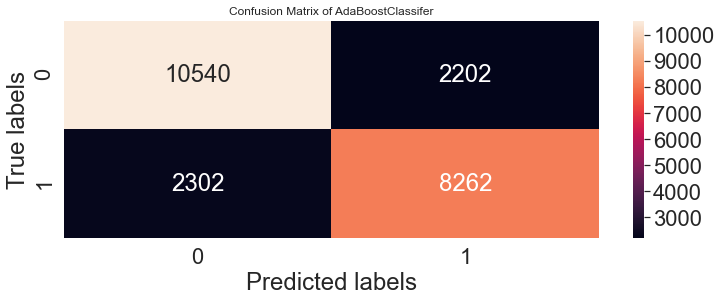

In [1141]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predada), annot=True, fmt='g');

# labels, title and ticks
sns.set(font_scale=1)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of AdaBoostClassifer')

In [1045]:
est_nm

array([[0.56105991, 0.55191325],
       [0.43894009, 0.44808675]])

## Method 2: Exploratory Analysis of Structured Bias, Grouped by `MSID`

The second method of uncovering label noise was based on the assumption that structured group bias was present within both datasets. 

By examining the trends and weighted averages of model inaccuracies, we can hope to uncover that perhaps some groups of `MSID` patients are continuously misclassified as `CHIP`, where originally labelled as `Control`.

In [289]:
# Split up training and testing with the same random state such that 
# rows and indicies appear in the same indices as the testing/training models

tX_train, tX_test, ty_train, ty_test = train_test_split(df.drop(['chipOrControl'], axis = 1), 
                                                    y, train_size=.8, random_state=0)

tX_train2, tX_test2, ty_train2, ty_test2 = train_test_split(df2.drop(['chipOrControl'], axis = 1), 
                                                    y2, train_size=.8, random_state=0)

testing = tX_test
testing2 = tX_test2

In [300]:
# Append new columns with the predicted classifications of the model
testing['ada_pred'] = pd.Series(y_predada).values
testing['rfc_pred'] = pd.Series(y_predrfc).values
testing['dct_pred'] = pd.Series(y_preddct).values
testing['knn_pred'] = pd.Series(y_predknn).values
testing['chipOrControl'] = ty_test

testing2['ada_pred'] = pd.Series(y_predada2).values
testing2['rfc_pred'] = pd.Series(y_predrfc2).values
testing2['dct_pred'] = pd.Series(y_preddct2).values
testing2['knn_pred'] = pd.Series(y_predknn2).values
testing2['chipOrControl'] = ty_test2

# Sort by MSID for plotting convenience
testing = testing.sort_values(by=['MSID'])
testing2 = testing2.sort_values(by=['MSID'])

In [384]:
# Create separate DataFrames, showing only rows where the model classification is not aligned with testing classifications

testing_ada = testing[testing['ada_pred'] != testing['chipOrControl']]
testing_dct = testing[testing['dct_pred'] != testing['chipOrControl']]
testing_knn = testing[testing['knn_pred'] != testing['chipOrControl']]
testing_rfc = testing[testing['rfc_pred'] != testing['chipOrControl']]

testing_ada2 = testing2[testing2['ada_pred'] != testing2['chipOrControl']]
testing_dct2 = testing2[testing2['dct_pred'] != testing2['chipOrControl']]
testing_knn2 = testing2[testing2['knn_pred'] != testing2['chipOrControl']]
testing_rfc2 = testing2[testing2['rfc_pred'] != testing2['chipOrControl']]

In [478]:
# Create new dataframe detailing inaccuracies of each model
msid_counts = pd.DataFrame()

msid_counts['x_train'] = testing.MSID.value_counts(sort=False)
msid_counts['x_train2'] = testing2.MSID.value_counts(sort=False)

msid_counts['ada'] = testing_ada.MSID.value_counts(sort=False)
msid_counts['ada2'] = testing_ada2.MSID.value_counts(sort=False)

msid_counts['rfc'] = testing_rfc.MSID.value_counts(sort=False)
msid_counts['rfc2'] = testing_rfc2.MSID.value_counts(sort=False)

msid_counts['dct'] = testing_dct.MSID.value_counts(sort=False)
msid_counts['dct2'] = testing_dct2.MSID.value_counts(sort=False)

msid_counts['knn'] = testing_knn.MSID.value_counts(sort=False)
msid_counts['knn2'] = testing_knn2.MSID.value_counts(sort=False)

`msid_counts` provide the frequency of inaccurate labellings for each model per dataset, while grouped by `MSID`.

In [479]:
msid_counts

,x_train,x_train2,ada,ada2,rfc,rfc2,dct,dct2,knn,knn2
MS5488,236,227,46,77,50,70,48,87,53,91
MS4410,328,299,54,102,119,135,61,107,65,122
MS6638,327,331,88,122,135,146,87,124,80,155
MS11186,180,239,36,101,76,121,42,110,47,106
MS15959,343,243,40,63,45,75,45,64,44,80
...,...,...,...,...,...,...,...,...,...,...
MS12764,443,495,51,140,70,174,63,153,59,154
MS12922,108,155,26,46,51,46,27,58,26,63
MS3780,370,426,70,126,81,122,80,130,56,140
MS10108,144,213,35,76,43,69,36,78,32,74


We can transform `msid_counts` to find percentage error per model by dividing the sum of frequency inaccuracies by total, denoted by `X_train` or `X_train2`respectively for both datasets.

Denote `pct_msid_counts` as the percentage error for a particualr dataset and its model.

In [482]:
pct_msid_counts = msid_counts.copy(deep=True)

pct_msid_counts['ada pct'] = pct_msid_counts.ada / pct_msid_counts.x_train 
pct_msid_counts['rfc pct'] = pct_msid_counts.rfc / pct_msid_counts.x_train 
pct_msid_counts['dct pct'] = pct_msid_counts.dct / pct_msid_counts.x_train 
pct_msid_counts['knn pct'] = pct_msid_counts.knn / pct_msid_counts.x_train 

pct_msid_counts['ada2 pct'] = pct_msid_counts.ada2 / pct_msid_counts.x_train2
pct_msid_counts['rfc2 pct'] = pct_msid_counts.rfc2 / pct_msid_counts.x_train2 
pct_msid_counts['dct2 pct'] = pct_msid_counts.dct2 / pct_msid_counts.x_train2 
pct_msid_counts['knn2 pct'] = pct_msid_counts.knn2 / pct_msid_counts.x_train2

pct_msid_counts.drop(['x_train', 'x_train2'], axis=1, inplace=True)

In [1148]:
pct_msid_counts.round(3)

,ada pct,rfc pct,dct pct,knn pct,ada2 pct,rfc2 pct,dct2 pct,knn2 pct
MS10080,0.271,0.372,0.264,0.310,0.341,0.493,0.363,0.390
MS10108,0.243,0.299,0.250,0.222,0.357,0.324,0.366,0.347
MS10284,0.203,0.416,0.255,0.271,0.443,0.500,0.426,0.523
MS10285,0.205,0.216,0.239,0.170,0.340,0.187,0.351,0.378
MS10716,0.249,0.249,0.240,0.141,0.387,0.390,0.379,0.398
...,...,...,...,...,...,...,...,...
MS8569,0.147,0.154,0.170,0.124,0.371,0.267,0.376,0.407
MS8886,0.230,0.426,0.241,0.213,0.395,0.571,0.415,0.405
MS917,0.347,0.408,0.306,0.388,0.367,0.467,0.400,0.420
MS9695,0.160,0.215,0.189,0.148,0.319,0.310,0.348,0.343


With the `pct_msid_counts` DataFrame, by averaging inaccuracies across models, separated by datasets, we can find the average error that a model will predict a `MSID`incorrectly.

In [491]:
pct_msid_counts1 = pct_msid_counts.drop(['ada2 pct', 'rfc2 pct', 'dct2 pct', 'knn2 pct'], axis=1)
pct_msid_counts2 = pct_msid_counts.drop(['ada pct', 'rfc pct', 'dct pct', 'knn pct'], axis=1)

In [502]:
errors = pd.DataFrame()
errors['run1_avg'] = pct_msid_counts1.T.mean()
errors['run2_avg'] = pct_msid_counts2.T.mean()

Denote `errors` as the average error rate a dataset will predict a `MSID` incorrectly.

In [973]:
errors

,run1_avg,run2_avg,chipOrControl
MS10080,0.304,0.397,Control
MS10108,0.253,0.349,CHIP
MS10284,0.286,0.473,Control
MS10285,0.207,0.314,CHIP
MS10716,0.220,0.389,CHIP
...,...,...,...
MS8569,0.149,0.355,CHIP
MS8886,0.277,0.446,Control
MS917,0.362,0.413,Control
MS9695,0.178,0.330,CHIP


Finally, by placing a filter on a minimum average, we can visualise which groups of `MSID` a model classifies inaccurately.
Particularly, we find that a 30 and 35% filter is appropriate, as this presents only 9 patients out of the total 88.

In [1155]:
higherror = errors.loc[(errors['run1_avg']>=0.3) & (errors['run2_avg']>= errors.run2_avg.mean())] # run2 avg = 0.354
higherror.style.set_caption("MSID with high inaccuracy rates per dataset, minimum 30% and 35% respectively")

,run1_avg,run2_avg,chipOrControl
MS10080,0.304264,0.396861,Control
MS13090,0.322981,0.428571,Control
MS13994,0.323864,0.441489,Control
MS17137,0.333916,0.444976,Control
MS5053,0.329646,0.399148,Control
MS5082,0.337500,0.462670,Control
MS7260,0.317235,0.524221,Control
MS8519,0.360390,0.403974,Control
MS917,0.362245,0.413333,Control


In [896]:
higherror_msid = higherror.index.array
higherror_msid

<PandasArray>
['MS10080', 'MS13090', 'MS13994', 'MS17137',  'MS5053',  'MS5082',  'MS7260',
  'MS8519',   'MS917']
Length: 9, dtype: object

## Assume that for the above MSID, labels are incorrect. 
### Flip models and rerun models:

In [887]:
df_flip = df.copy(deep=True)
df_flip2 = df2.copy(deep=True)

for msid in higherror_msid:
    df_flip.loc[df_flip.MSID == msid, "chipOrControl"] = 0

for msid in higherror_msid:
    df_flip2.loc[df_flip2.MSID == msid, "chipOrControl"] = 0
    
Xf = df_flip.drop(['MSID', 'chipOrControl'], axis = 1) 
yf = df_flip['chipOrControl'] 
X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf, yf, train_size=.8, random_state=0)

X2f = df2.drop(['MSID', 'chipOrControl'], axis = 1) 
y2f = df2['chipOrControl'] 
X_train2f, X_test2f, y_train2f, y_test2f = train_test_split(X2f, y2f, train_size=.8, random_state=2)

### AdaBoost Flipped 

In [904]:
adaf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
adaf.fit(X_trainf, y_trainf)
y_predadaf = adaf.predict(X_testf)
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predadaf),3)))

Accuracy 0.823


In [908]:
adaf2 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate = 0.5, algorithm= 'SAMME')
adaf2.fit(X_train2f, y_train2f)
y_predadaf2 = adaf2.predict(X_test2f)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predadaf2),3)))

Accuracy 0.692


### KNN Flipped

In [912]:
for i in range(2, 10):
    knnf = KNeighborsClassifier(n_neighbors = i, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
    knnf.fit(X_trainf, y_trainf)
    y_predknnf = knnf.predict(X_testf)
    print(i, 'Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predknnf),3)))

2 Accuracy 0.821
3 Accuracy 0.825
4 Accuracy 0.826
5 Accuracy 0.823
6 Accuracy 0.824
7 Accuracy 0.823
8 Accuracy 0.821
9 Accuracy 0.82


In [915]:
for i in range(10, 15):
    knn2f = KNeighborsClassifier(n_neighbors = i, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
    knn2f.fit(X_train2f, y_train2f)
    y_predknn2f = knn2f.predict(X_test2f)
    print(i, 'Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predknn2f),3)))

10 Accuracy 0.63
11 Accuracy 0.629
12 Accuracy 0.632
13 Accuracy 0.632
14 Accuracy 0.633


In [924]:
knnf = KNeighborsClassifier(n_neighbors = 4, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
knnf.fit(X_trainf, y_trainf)
y_predknnf = knnf.predict(X_testf)
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predknnf),3)))

Accuracy 0.826


In [926]:
knn2f = KNeighborsClassifier(n_neighbors = 14, weights='distance', metric = 'manhattan', algorithm = 'kd_tree')
knn2f.fit(X_train2f, y_train2f)
y_predknn2f = knn2f.predict(X_test2f)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predknn2f),3)))

Accuracy 0.633


### RFC Flipped

In [918]:
rfcf = RandomForestClassifier(n_estimators = 100)
rfcf.fit(X_trainf, y_trainf)
y_predrfcf = rfcf.predict(X_testf)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predrfcf),3)))

Accuracy 0.736


In [921]:
rfc2f = RandomForestClassifier(n_estimators = 100)
rfc2f.fit(X_train2f, y_train2f)
y_predrfc2f = rfc2f.predict(X_test2f)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predrfc2f),3)))

Accuracy 0.629


### DCT Flipped

In [927]:
dtf = DecisionTreeClassifier()
dtf.fit(X_trainf, y_trainf)
y_preddctf = dtf.predict(X_testf)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_preddctf),3)))

Accuracy 0.793


In [922]:
dt2f = DecisionTreeClassifier()
dt2f.fit(X_train2f, y_train2f)
y_preddt2f = dt2f.predict(X_test2f)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_preddt2f),3)))

Accuracy 0.66


### Logistic Regression Flipped

In [929]:
logregf = LogisticRegression(multi_class='ovr')
logregf.fit(X_trainf, y_trainf)
y_predlogregf = logregf.predict(X_testf)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predlogregf),3)))

Accuracy 0.599


In [930]:
logreg2f = LogisticRegression(multi_class='ovr')
logreg2f.fit(X_train2f, y_train2f)
y_predlogreg2f = logreg.predict(X_test2f)  
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predlogreg2f),3)))

Accuracy 0.521


### Gaussian Naive Bayes Flipped

In [961]:
gnbf = GaussianNB()
gnbf.fit(X_trainf, y_trainf)
y_predgnbf = gnbf.predict(X_testf)
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predgnbf),3)))

Accuracy 0.463


In [932]:
gnb2f = GaussianNB()
gnb2f.fit(X_train2f, y_train2f)
y_predgnb2f = gnb2f.predict(X_test2f)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predgnb2f),3)))

Accuracy 0.488


### XGBoost Classifer Flipped

In [933]:
xgf = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
xgf.fit(X_trainf,y_trainf)
y_predxgbf = xgf.predict(X_testf)
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predxgbf),3)))

Accuracy 0.763


In [934]:
xg2f = XGBClassifier(objective='binary:logistic', n_estimators=1000,seed=1, eval_metric='logloss', n_jobs = -1)
xg2f.fit(X_train2f,y_train2f)
y_predxgb2f = xg2f.predict(X_test2f)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predxgb2f),3)))

Accuracy 0.632


### Light Gradient Boosting Flipped

In [935]:
lgbf = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lgbf.fit(X_trainf, y_trainf)
y_predlgbf = lgbf.predict(X_testf)
print('Accuracy {0}'.format(np.round(accuracy_score(y_testf, y_predlgbf),3)))

Accuracy 0.697


In [936]:
lgb2f = LGBMClassifier(n_estimators=1000, num_leaves = 40, n_jobs = -1)
lgb2f.fit(X_train2f, y_train2f)
y_predlgb2f = lgb2f.predict(X_test2f)
print('Accuracy {0}'.format(np.round(accuracy_score(y_test2f, y_predlgb2f),3)))

Accuracy 0.623


# 6. Final Results
Finally, now that all accuracy of models have been run over both datasets under different conditions, place all accuracy results into DataFrames and visualise performance of each model.

In [780]:
res1 = {}
res2 = {}

res1['K Neighbours'] = np.round(accuracy_score(y_test, y_predknn),3)*100
res2['K Neighbours'] = np.round(accuracy_score(y_test2, y_predknn2),3)*100

res1['Random Forest'] = np.round(accuracy_score(y_test, y_predrfc),3)*100
res2['Random Forest'] = np.round(accuracy_score(y_test2, y_predrfc2),3)*100

res1['AdaBoost'] = np.round(accuracy_score(y_test, y_predada),3)*100
res2['AdaBoost'] = np.round(accuracy_score(y_test2, y_predada2),3)*100

res1['XG Boost'] = np.round(accuracy_score(y_test, y_predxgb),3)*100
res2['XG Boost'] = np.round(accuracy_score(y_test2, y_predxgb2),3)*100

res1['Decision Trees'] = np.round(accuracy_score(y_test, y_preddct),3)*100
res2['Decision Trees'] = np.round(accuracy_score(y_test2, y_preddct2),3)*100

res1['Logistic Regression'] = np.round(accuracy_score(y_test, y_predlogreg),3)*100
res2['Logistic Regression'] = np.round(accuracy_score(y_test2, y_predlogreg2),3)*100

res1['Guassian Naive Bayes'] = np.round(accuracy_score(y_test, y_predgnb),3)*100
res2['Guassian Naive Bayes'] = np.round(accuracy_score(y_test2, y_predgnb2),3)*100

res1['Light Gradient Boosting'] = np.round(accuracy_score(y_test, y_predlgb),3)*100
res2['Light Gradient Boosting'] = np.round(accuracy_score(y_test2, y_predlgb2),3)*100

In [952]:
results = pd.DataFrame()
results['Dataset 1'] = pd.Series(res1)
results['Dataset 2'] = pd.Series(res2)
results

,Dataset 1,Dataset 2
K Neighbours,81.500,63.000
Random Forest,72.300,62.500
AdaBoost,80.700,68.900
XG Boost,75.600,63.200
Decision Trees,78.800,66.100
Logistic Regression,54.700,52.100
Guassian Naive Bayes,52.700,48.800
Light Gradient Boosting,67.500,62.300


## `cleanlab` Results

In [1115]:
res1_cleanlab = {}
res2_cleanlab = {}

res1_cleanlab['K Neighbours'] = np.round(accuracy_score(y_testf, pred_lnl_knn1),3)*100
res2_cleanlab['K Neighbours'] = np.round(accuracy_score(y_test2f, pred_lnl_knn2),3)*100

res1_cleanlab['Random Forest'] = np.round(accuracy_score(y_testf, pred_lnl_rfc1),3)*100
res2_cleanlab['Random Forest'] = np.round(accuracy_score(y_test2f, pred_lnl_rfc2),3)*100

res1_cleanlab['AdaBoost'] = np.round(accuracy_score(y_testf, pred_lnl_ada1),3)*100
res2_cleanlab['AdaBoost'] = np.round(accuracy_score(y_test2f, pred_lnl_ada2),3)*100

res1_cleanlab['XG Boost'] = np.round(accuracy_score(y_testf, pred_lnl_xg1),3)*100
res2_cleanlab['XG Boost'] = np.round(accuracy_score(y_test2f, pred_lnl_xg2),3)*100

res1_cleanlab['Decision Trees'] = np.round(accuracy_score(y_testf, pred_lnl_dct1),3)*100
res2_cleanlab['Decision Trees'] = np.round(accuracy_score(y_test2f, pred_lnl_dct2),3)*100

res1_cleanlab['Logistic Regression'] = np.round(accuracy_score(y_testf, pred_lnl_log1),3)*100
res2_cleanlab['Logistic Regression'] = np.round(accuracy_score(y_test2f, pred_lnl_log2),3)*100

res1_cleanlab['Guassian Naive Bayes'] = np.round(accuracy_score(y_testf, pred_lnl_gb1),3)*100
res2_cleanlab['Guassian Naive Bayes'] = np.round(accuracy_score(y_test2f, pred_lnl_gb2),3)*100

res1_cleanlab['Light Gradient Boosting'] = np.round(accuracy_score(y_testf, pred_lnl_lg1),3)*100
res2_cleanlab['Light Gradient Boosting'] = np.round(accuracy_score(y_test2f, pred_lnl_lg2),3)*100

In [1116]:
results_lnl = pd.DataFrame()
results_lnl['Cleanlab Dataset 1'] = pd.Series(res1_cleanlab)
results_lnl['Cleanlab Dataset 2'] = pd.Series(res2_cleanlab)
results_lnl

,Cleanlab Dataset 1,Cleanlab Dataset 2
K Neighbours,76.600,60.100
Random Forest,68.500,60.100
AdaBoost,75.900,64.700
XG Boost,71.600,62.400
Decision Trees,73.200,60.200
Logistic Regression,53.800,51.600
Guassian Naive Bayes,44.200,49.000
Light Gradient Boosting,64.900,60.600


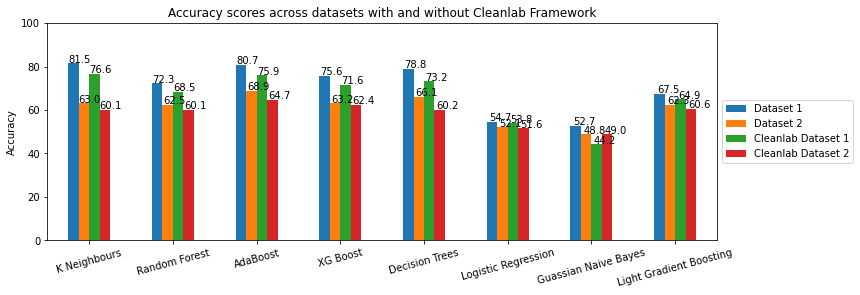

In [1129]:
res_lnl = pd.concat([results, results_lnl],axis=1)

ax = res_lnl.round(2).plot(kind='bar', rot=15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height()*1.005))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Accuracy")
plt.title("Accuracy scores across datasets with and without Cleanlab Framework")
plt.ylim(0, 100, 10);

As previously stated, the accuracy score on the models are subpar, hence, can conclude are not a reliable method of detecting false classifications of `control` within the dataset.

In future, perhaps investigating the mathematics more in-depth would aide the performance of these models.

Further investigations would start with this paper, *Confident Learning: Estimating Uncertainty in Dataset Labels*:
https://arxiv.org/abs/1911.00068

## Flipped MSID Models Results

In [940]:
res1f = {}
res2f = {}

res1f['K Neighbours'] = np.round(accuracy_score(y_testf, y_predknnf),3)*100
res2f['K Neighbours'] = np.round(accuracy_score(y_test2f, y_predknn2f),3)*100

res1f['Random Forest'] = np.round(accuracy_score(y_testf, y_predrfcf),3)*100
res2f['Random Forest'] = np.round(accuracy_score(y_test2f, y_predrfc2f),3)*100

res1f['AdaBoost'] = np.round(accuracy_score(y_testf, y_predadaf),3)*100
res2f['AdaBoost'] = np.round(accuracy_score(y_test2f, y_predadaf2),3)*100

res1f['XG Boost'] = np.round(accuracy_score(y_testf, y_predxgb),3)*100
res2f['XG Boost'] = np.round(accuracy_score(y_test2f, y_predxgb2),3)*100

res1f['Decision Trees'] = np.round(accuracy_score(y_testf, y_preddctf),3)*100
res2f['Decision Trees'] = np.round(accuracy_score(y_test2f, y_preddt2f),3)*100

res1f['Logistic Regression'] = np.round(accuracy_score(y_testf, y_predlogregf),3)*100
res2f['Logistic Regression'] = np.round(accuracy_score(y_test2f, y_predlogreg2f),3)*100

res1f['Guassian Naive Bayes'] = np.round(accuracy_score(y_testf, y_predgnbf),3)*100
res2f['Guassian Naive Bayes'] = np.round(accuracy_score(y_test2f, y_predgnb2f),3)*100

res1f['Light Gradient Boosting'] = np.round(accuracy_score(y_testf, y_predlgbf),3)*100
res2f['Light Gradient Boosting'] = np.round(accuracy_score(y_test2f, y_predlgb2f),3)*100

In [947]:
results2 = pd.DataFrame()
results2['Dataset 1 Flipped'] = pd.Series(res1f)
results2['Dataset 2 Flipped'] = pd.Series(res2f)
results2

,Dataset 1 Flipped,Dataset 2 Flipped
K Neighbours,82.600,63.300
Random Forest,73.600,62.900
AdaBoost,82.300,69.200
XG Boost,74.400,63.200
Decision Trees,79.300,66.000
Logistic Regression,59.900,52.100
Guassian Naive Bayes,46.300,48.800
Light Gradient Boosting,69.700,62.300


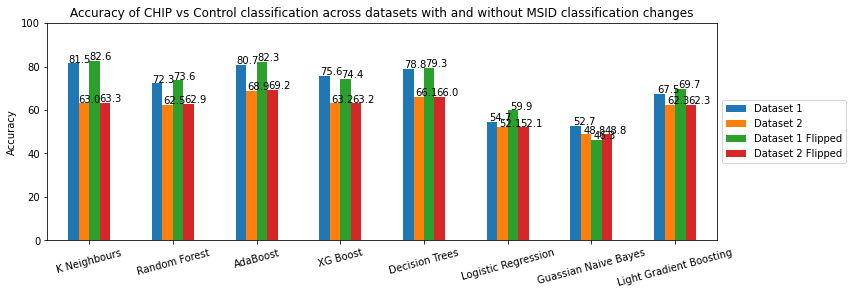

In [1128]:
restotal = pd.concat([results, results2],axis=1)
restotal

ax = restotal.round(2).plot(kind='bar', rot=15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height()*1.005))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Accuracy")
plt.title("Accuracy of CHIP vs Control classification across datasets with and without MSID classification changes")
plt.ylim(0, 100, 10);

By flipping the `MSID` of commonly misclassified patients, we visualise that the accuracy of most models increase by a range of 1-5%.

Thus, this method via data investigation of structured bias produced favourable results, given that accuracies of better performing models had all increased.

# 7. Conclusions

From noise label investigation, its uncovered that the `cleanlab` package was not useful in finding misclassified labels given structured bias in `MSID` misclassification. 

However, further data analysis elucidated particular groups of patients who were continously misclassified (`MSID`: `MS7260` especially with over 50% misclassification rate). As a result, by visualising these trends in data, under the assumption that these sets of labels are ones which are indeed under sequencing noise, have improved our models by changing the labels of these patients.